# Using TF Implementation of RNN to Make Predictions

In [57]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *

from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Importing Data

In [58]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")
targets = ['CashIn', 'CashOut']
atm_df = get_atm(df, 26637)
atm_df = atm_df[:-135]
atm_df = clean_data(atm_df, drop_zeros=True)
feature_set = get_feature_sets(atm_df, ['CashIn', 'CashOut'])

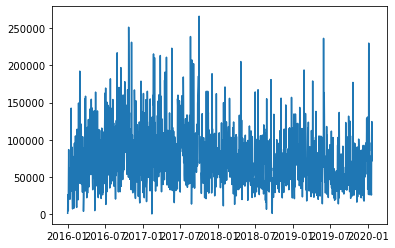

In [59]:
plt.plot(atm_df['CashIn'])

In [60]:
TARGET = 'CashIn'
X_train, X_test, y_train, y_test = train_test_split(feature_set[feature_set.columns[2:]], feature_set[TARGET], shuffle = False)

In [61]:
def get_input_sets(df, feature_groups):
    set_of_features = []
    for group in feature_groups:
        set_of_features.append(df[group])
    return set_of_features

## Baseline Score

I will begin with training a model using past n days of CashIn as input

In [62]:
N_TIMESTEPS = 14
feature_groups = [['%s_t-%d'%(TARGET, i)for i in range(1,N_TIMESTEPS + 1)]]

train_inputs = get_input_sets(X_train, feature_groups)
test_inputs  = get_input_sets(X_test, feature_groups)

In [69]:
# inputs shape = [batch, timesteps, feature]
base_input   = layers.Input(shape=(N_TIMESTEPS, 1))
base_rnn     = layers.SimpleRNN(32)(base_input)
base_dropout = layers.Dropout(0.1)(base_rnn)
base_dense1  = layers.Dense(16, activation='relu')(base_dropout)
base_output  = layers.Dense(1)(base_dense1)

base_model = keras.Model(inputs=[base_input], outputs = [base_output])
base_model.summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 14, 1)]           0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 32)                1088      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [70]:
base_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mape')

In [71]:
history = base_model.fit(train_inputs, 
            y_train,
            batch_size=32,
            epochs=50,
            validation_data=(test_inputs, y_test),
            verbose = 0)

In [72]:
def plot_history(history):
    plt.figure(figsize=(10,4))
    for key in history.history:
        plt.plot(history.history[key], label = key)
    plt.legend()
    plt.show()

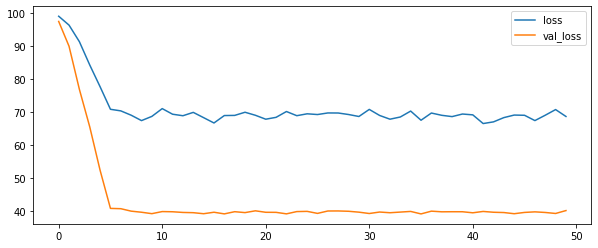

In [73]:
plot_history(history)

In [74]:
"min_loss: %.4f, min_val_loss: %.4f" % (min(history.history['loss']), min(history.history['val_loss']))

'min_loss: 66.5411, min_val_loss: 39.1308'

### Comparing with Previous Methods

| Model | Train Error | Test Error | All Set Error |
| - | - | - | - |
| Base | - | - | 78.8 |
| Random Forest | 23.9 | 47.0 | - |
| LGBM | - | 48.7 | - |
| TF Custom RNN | - | - | 70.7 |
| Keras, PP + Dense (with one dropout layer) | 21.7 | 37.8 | - |
| Keras, PP + Dense (with two dropout layers) | 25.3 | 36.9 | - |
| Keras, RNN + Dense (Single Feature, Baseline) | 66.9 | 39.1 | - |

I am not sure about the cause of the high training error in the base model.

## Preparing Multiple Feature Data for Keras RNN Model

We can't use the feature set we had been using until now. The required shape ([batch, timesteps, feature]) doesn't match. <p>

I will first choose the feature sets I want to use as input and then apply a new create_rnn_window method.

In [76]:
feature_set

,CashIn,CashOut,CashIn_average_7,CashIn_average_30,CashOut_average_7,CashOut_average_30,CashIn_trend_7,CashOut_trend_7,CashIn_t-1,CashIn_t-2,...,Day_Of_the_Month_Index,Is_Weekday,Is_Weekend,curr_month_1_delta,curr_month_15_delta,next_month_1_delta,is_ramazan,ramazan_in_7_days,is_kurban,kurban_in_7_days
HistoryDate,,,,,,,,,,,,,,,,,,,,,
2016-02-10,55320.0,36480.0,56012.857143,55019.000000,49010.000000,42199.333333,119250.000000,60210.0,46460.0,105080.0,...,10,1,0,-9,5,20,0,0,0,0
2016-02-11,60830.0,44650.0,50308.571429,54788.000000,47637.142857,41935.000000,-11210.000000,117440.0,55320.0,46460.0,...,11,1,0,-10,4,19,0,0,0,0
2016-02-12,62010.0,47450.0,54472.857143,56149.333333,44078.571429,41744.333333,33823.333333,67740.0,60830.0,55320.0,...,12,1,0,-11,3,18,0,0,0,0
2016-02-13,10770.0,40530.0,58363.333333,56380.333333,42825.714286,41925.000000,11366.666667,41870.0,62010.0,60830.0,...,13,0,1,-12,2,17,0,0,0,0
2016-02-14,9040.0,27210.0,54491.428571,54747.333333,42490.000000,42602.000000,74070.000000,32320.0,10770.0,62010.0,...,14,0,1,-13,1,16,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-18,30525.0,54400.0,48927.857143,79400.000000,81905.714286,61610.333333,53600.000000,77760.0,59380.0,41350.0,...,18,0,1,-17,-3,14,0,0,0,0
2020-01-19,25695.0,37820.0,44968.571429,77929.333333,79742.857143,61896.666667,25385.000000,64300.0,30525.0,59380.0,...,19,0,1,-18,-4,13,0,0,0,0
2020-01-20,102685.0,64440.0,44942.857143,75697.833333,78112.857143,61207.000000,-125250.000000,64890.0,25695.0,30525.0,...,20,1,0,-19,-5,12,0,0,0,0


In [77]:
feature_set_np = feature_set.to_numpy()

In [78]:
feature_set_np.shape

(1443, 80)

In [79]:
N_TIMESTEPS = 7
to_merge = []
for i in range(N_TIMESTEPS + 1):
    timestep = np.roll(feature_set_np, i, axis=0)
    to_merge.append(timestep)
rnn_df = np.swapaxes(np.dstack(to_merge), 1, 2)
rnn_df = rnn_df[N_TIMESTEPS:]       # remove wrong groups
rnn_df = np.flip(rnn_df, axis = 1)  # flip the timesteps axis to start with the first observation
rnn_df.shape

(1436, 8, 80)

In [80]:
X = rnn_df[:, 1:, :]
y = rnn_df[:, 0, 0 if TARGET=='CashIn' else 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

## Training Model with RNN Layer

In [101]:
# inputs shape = [batch, timesteps, feature]
rnn_input   = layers.Input(shape=(N_TIMESTEPS, 80))
rnn_layer   = layers.SimpleRNN(32)(rnn_input)
rnn_dropout = layers.Dropout(0.1)(rnn_layer)
rnn_dense1  = layers.Dense(16)(rnn_dropout)
rnn_output  = layers.Dense(1)(rnn_dense1)

rnn_model = keras.Model(inputs=[rnn_input], outputs = [rnn_output])
rnn_model.summary()

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 7, 80)]           0         
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 32)                3616      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 17        
Total params: 4,161
Trainable params: 4,161
Non-trainable params: 0
_________________________________________________________________


In [102]:
rnn_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mape')

In [103]:
history = rnn_model.fit(X_train, 
            y_train,
            batch_size=32,
            epochs=200,
            validation_data=(X_test, y_test),            
            verbose = 0)

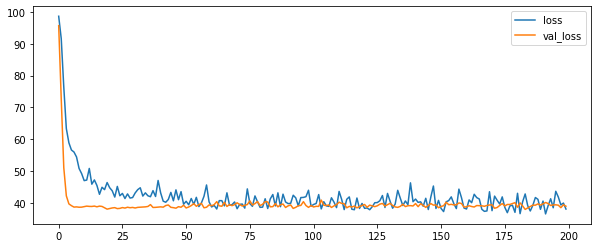

In [104]:
plot_history(history)

In [105]:
"min_loss: %.4f, min_val_loss: %.4f" % (min(history.history['loss']), min(history.history['val_loss']))

'min_loss: 36.5376, min_val_loss: 37.9523'

### Comparing with Previous Methods

| Model | Train Error | Test Error | All Set Error |
| - | - | - | - |
| Base | - | - | 78.8 |
| Random Forest | 23.9 | 47.0 | - |
| LGBM | - | 48.7 | - |
| TF Custom RNN | - | - | 70.7 |
| Keras, PP + Dense (with one dropout layer) | 21.7 | 37.8 | - |
| Keras, PP + Dense (with two dropout layers) | 25.3 | 36.9 | - |
| Keras, RNN + Dense (Single Feature, Baseline) | 66.9 | 39.1 | - |
| Keras, RNN + Dense (All Features in the Set) | 36.5 | 37.9 | - |

## Training Model with LSTM Layer

In [109]:
# inputs shape = [batch, timesteps, feature]
lstm_input   = layers.Input(shape=(N_TIMESTEPS, 80))
lstm_layer   = layers.LSTM(32)(lstm_input)
lstm_dropout = layers.Dropout(0.1)(lstm_layer)
lstm_dense1  = layers.Dense(32, activation='relu')(lstm_dropout)
lstm_dense2  = layers.Dense(16, activation='relu')(lstm_dense1)
lstm_output  = layers.Dense(1)(lstm_dense2)

lstm_model = keras.Model(inputs=[lstm_input], outputs = [lstm_output])
lstm_model.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 7, 80)]           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                14464     
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_38 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________

In [110]:
lstm_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mape')

In [111]:
history = lstm_model.fit(X_train, 
            y_train,
            batch_size=32,
            epochs=500,
            validation_data=(X_test, y_test),            
            verbose = 0)

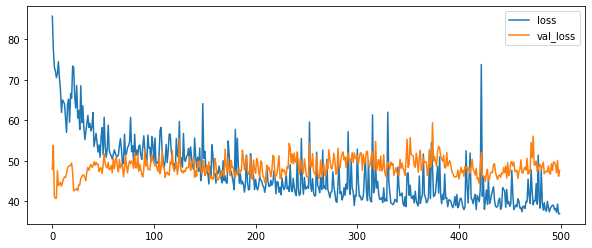

In [112]:
plot_history(history)

In [113]:
"min_loss: %.4f, min_val_loss: %.4f" % (min(history.history['loss']), min(history.history['val_loss']))

'min_loss: 36.8954, min_val_loss: 40.7382'

### Comparing with Previous Methods

| Model | Train Error | Test Error | All Set Error |
| - | - | - | - |
| Base | - | - | 78.8 |
| Random Forest | 23.9 | 47.0 | - |
| LGBM | - | 48.7 | - |
| TF Custom RNN | - | - | 70.7 |
| Keras, PP + Dense (with one dropout layer) | 21.7 | 37.8 | - |
| Keras, PP + Dense (with two dropout layers) | 25.3 | 36.9 | - |
| Keras, RNN + Dense (Single Feature, Baseline) | 66.9 | 39.1 | - |
| Keras, RNN + Dense (All Features in the Set) | 39.0 | 36.2 | - |
| Keras, LSTM + Dense (All Features in the Set) | 36.9 | 40.7 | - |